In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
all_nodes = pd.read_csv("terrorist_attack.nodes", header = None, sep="\t", encoding="utf-8")
edges = pd.read_csv("terrorist_attack_loc.edges", header = None, sep="\t", encoding="utf-8")
labels = pd.read_csv("terrorist_attack.labels", header = None, sep="\t", encoding="utf-8")
edges = edges[0].str.split(' ',expand=True)
labels_extracted = all_nodes[107].str.split('#',expand=True)
labels = labels_extracted[1]
labels = labels.values
all_nodes[0][120]
features = all_nodes.values[:,1:107]

### Adjacency Matrix:

In [2]:
n_nodes = len(all_nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
number_link = 0
n2 = 0

for idx, row in edges.iterrows():
    
    i = np.where(all_nodes[0] == row.loc[0])
    j = np.where(all_nodes[0] == row.loc[1])
    n2 = n2 + 1
    
    if (i[0].size != 0 and j[0].size != 0):
        adjacency[i[0], j[0]] = 1
        adjacency[j[0], i[0]] = 1
        number_link = number_link + 1

In [3]:
adjacency.shape

(1293, 1293)

Text(0.5, 1.05, 'adjacency matrix')

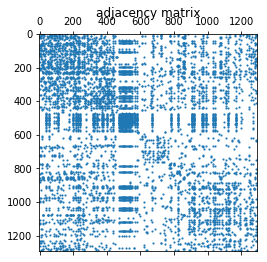

In [4]:
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')

In [5]:
degree =  sum(adjacency)

assert len(degree) == n_nodes

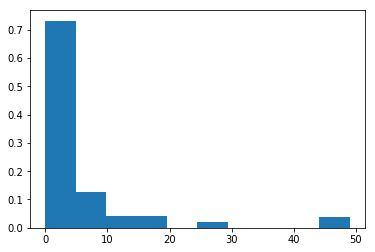

In [6]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

In [7]:
def BFS(adjacency, labels, state):
    """
    return a component with an array of updated labels (the visited nodes during the BFS)
    for a given adjacency matrix
    
    :param adjacency: The adjacency matrix where to find the component
    :param labels: An array of labels (0 : the node is not yet explored, 1: it is explored)
    :param state: The # of the component we are looking for
    :return: updated labels array and the component found
    """
    queue = []
    # current node is the first one with a label to 0
    current_node = np.argwhere(labels == 0).flatten()[0]
    labels[current_node] = state
    queue.append(current_node)

    current_component = []
    current_component.append(current_node)
    
    while len(queue) != 0:
        # all the weight of the other nodes for a given one
        all_nodes = adjacency[current_node]
        # all the nodes reachable from the current one that are not yet labeled
        neighbours = np.argwhere((all_nodes > 0) & (labels == 0)).flatten()
        # add those nodes to the queue and to the component
        queue += list(neighbours)
        current_component += list(neighbours)
        
        for i in neighbours:
            # we update the labels array
            labels[i] = state
        if len(queue) > 1:
            # and we update the queue and the current node
            queue = queue[1:]
            current_node = queue[0]
        else :
            queue = []
    
    return np.array(labels), current_component

In [128]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    #Find the first component
    components = []
    first_labels = np.zeros(n_nodes, dtype=int)
    labels, component = BFS(adjacency, first_labels, 1)
    components.append(component)
    current_state = 2
    
    #Redo BFS while we haven't found all the components
    while (labels > 0).sum() != n_nodes:
        labels, component = BFS(adjacency, labels, current_state)
        components.append(component)
        current_state += 1
        
    return np.array(components)

In [132]:
LC = find_components(adjacency);
LC = sorted(LC,key=len);
len(LC[783])
#LC[786]

19

In [123]:
def find_outliers(node_list):
    outliers = list()
    for i in range(0, len(node_list)):
        for j in range(i,len(node_list)):
            if (adjacency[node_list[i]][node_list[j]] == 0):
                if i != j:
                    if node_list[j] not in outliers:
                        outliers.append(node_list[j])
    return outliers

In [144]:
find_outliers(LC[783])

[]

Giant Component 

In [11]:
G = nx.from_numpy_matrix(adjacency)
graphs = nx.connected_component_subgraphs(G)
graphs = list(graphs)
graphs;

787


In [12]:
giant = max(graphs, key=len)
sorted_graphs = sorted(graphs, key=len)
second_giant_graph = sorted_graphs[785]
third_giant_graph = sorted_graphs[784]
fourth_giant_graph = sorted_graphs[783]
ss = nx.to_scipy_sparse_matrix(second_giant_graph)
ts = nx.to_scipy_sparse_matrix(third_giant_graph)
fs =  nx.to_scipy_sparse_matrix(fourth_giant_graph)
second_giant = ss.todense()
third_giant = ts.todense()
fourth_giant = fs.todense()

In [13]:
A = nx.to_scipy_sparse_matrix(giant)
giant_component = A.todense()

In [14]:
giant_component.shape

(51, 51)

In [15]:
second_giant.shape
third_giant.shape
fourth_giant.shape

(19, 19)

In [16]:
GG = nx.from_numpy_matrix(giant_component)
GG2 = nx.from_numpy_matrix(second_giant)
GG3 = nx.from_numpy_matrix(third_giant)
GG4 = nx.from_numpy_matrix(fourth_giant)

### Laplacian 

In [17]:
deg_matrix = np.diag(degree)
laplacian_combinatorial =  scipy.sparse.csr_matrix(deg_matrix - adjacency)

In [18]:
deg_giant = np.sum(giant_component, axis=0)
deg_giant_matrix = np.diag(deg_giant)

giant_laplacian =  scipy.sparse.csr_matrix(deg_giant_matrix - giant_component)

e, U = scipy.linalg.eig(giant_laplacian.toarray())
inds = e.argsort()
U = U[inds]
e = np.sort(e)

lmax = e[50]

In [19]:
deg_second_giant = np.sum(second_giant, axis = 0)
deg_second_giant_matrix = np.diag(deg_second_giant)

second_giant_laplacian = scipy.sparse.csr_matrix(deg_second_giant_matrix - second_giant)
e2, U2 = scipy.linalg.eig(second_giant_laplacian.toarray())
inds2 = e2.argsort()
U2 = U2[inds2]
e2 = np.sort(e2)


In [20]:
deg_third_giant = np.sum(third_giant, axis = 0)
deg_third_giant_matrix = np.diag(deg_third_giant)

third_giant_laplacian = scipy.sparse.csr_matrix(deg_third_giant_matrix - third_giant)
e3, U3 = scipy.linalg.eig(third_giant_laplacian.toarray())
inds3 = e3.argsort()
U3 = U3[inds3]
e3 = np.sort(e3)


In [21]:
deg_fourth_giant = np.sum(fourth_giant, axis = 0)
deg_fourth_giant_matrix = np.diag(deg_fourth_giant)

fourth_giant_laplacian = scipy.sparse.csr_matrix(deg_fourth_giant_matrix - fourth_giant)
e4, U4 = scipy.linalg.eig(fourth_giant_laplacian.toarray())
inds4 = e4.argsort()
U4 = U4[inds4]
e4 = np.sort(e4)


### Graph Plot


C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


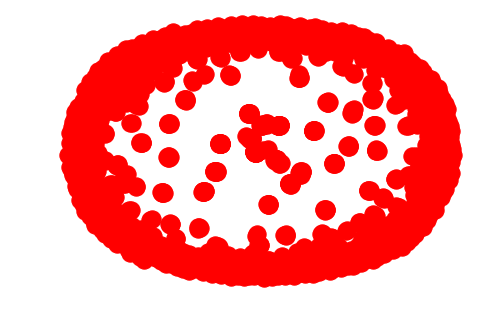

In [22]:
# Complete Graph
nx.draw(G)

In [25]:
# Giant Component Graph
GG.remove_nodes_from({1,35}) # removed node 1244 and 129

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Fully Connected Giant Component')

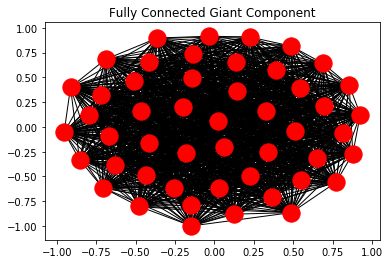

In [147]:
nx.draw_networkx(GG, with_labels=False)
plt.title("Fully Connected Giant Component")


In [26]:
# Second Giant Component Graph
#nx.draw(GG2)
GG2.remove_nodes_from({0,4,25}) # removed nodes 115 128 151


C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Fully Connected 2nd component')

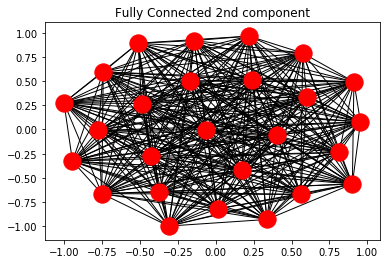

In [148]:
nx.draw_networkx(GG2, with_labels=False)
plt.title("Fully Connected 2nd component")

In [28]:
GG3.remove_node(7) # removed node 1232


C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Fully Connected 3rd component')

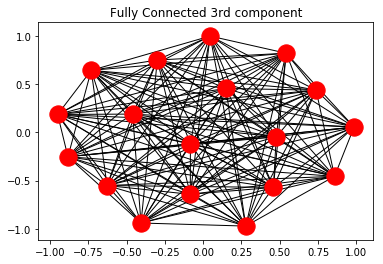

In [149]:
nx.draw_networkx(GG3, with_labels=False)
plt.title("Fully Connected 3rd component")

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Fully Connected 4th component')

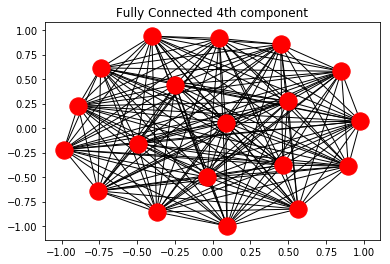

In [150]:
nx.draw_networkx(GG4, with_labels=False)
plt.title("Fully Connected 4th component")

### Labels 

In [133]:
#GG.remove_nodes_from({1,35})
LC[786].remove(1244)
LC[786].remove(129)
labels_giant = labels[LC[786]]
len(labels_giant)

49

In [137]:
LC[785].remove(115)
LC[785].remove(128)
LC[785].remove(151)
labels_second_giant = labels[LC[785]]
#sorted(second_giant_graph.nodes);
labels_second_giant

array(['Arson', 'Arson', 'Bombing', 'Bombing', 'Bombing', 'Bombing',
       'Bombing', 'Bombing', 'Bombing', 'Bombing', 'Bombing', 'Bombing',
       'Bombing', 'Bombing', 'Bombing', 'Bombing', 'Bombing', 'Bombing',
       'Bombing', 'Bombing', 'Weapon_Attack', 'Weapon_Attack',
       'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack'],
      dtype=object)

In [141]:
LC[784].remove(1232)
labels_third_giant = labels[LC[784]]
#sorted(third_giant_graph.nodes);
labels_third_giant

array(['Bombing', 'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack',
       'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack',
       'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack',
       'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack',
       'Weapon_Attack', 'Weapon_Attack'], dtype=object)

In [151]:
labels_fourth_giant = labels[LC[783]]
#sorted(fourth_giant_graph.nodes);
labels_fourth_giant

array(['Arson', 'Arson', 'Arson', 'Bombing', 'Bombing', 'Bombing',
       'Bombing', 'Bombing', 'Bombing', 'Bombing', 'Bombing', 'Bombing',
       'Bombing', 'Kidnapping', 'Kidnapping', 'Kidnapping',
       'Weapon_Attack', 'Weapon_Attack', 'Weapon_Attack'], dtype=object)

In [134]:
labels_giant[labels_giant == 'Arson'] = 1
labels_giant[labels_giant == 'Bombing'] = 2
labels_giant[labels_giant == 'Weapon_Attack'] = 3
labels_giant[labels_giant == 'other_attack'] = 4
labels_giant[labels_giant == 'Kidnapping'] = 5

In [138]:
labels_second_giant[labels_second_giant == 'Arson'] = 1
labels_second_giant[labels_second_giant == 'Bombing'] = 2
labels_second_giant[labels_second_giant == 'Weapon_Attack'] = 3
labels_second_giant[labels_second_giant == 'other_attack'] = 4
labels_second_giant[labels_second_giant == 'Kidnapping'] = 5

In [142]:
labels_third_giant[labels_third_giant == 'Arson'] = 1
labels_third_giant[labels_third_giant == 'Bombing'] = 2
labels_third_giant[labels_third_giant == 'Weapon_Attack'] = 3
labels_third_giant[labels_third_giant == 'other_attack'] = 4
labels_third_giant[labels_third_giant == 'Kidnapping'] = 5

In [152]:
labels_fourth_giant[labels_fourth_giant == 'Arson'] = 1
labels_fourth_giant[labels_fourth_giant == 'Bombing'] = 2
labels_fourth_giant[labels_fourth_giant == 'Weapon_Attack'] = 3
labels_fourth_giant[labels_fourth_giant == 'other_attack'] = 4
labels_fourth_giant[labels_fourth_giant == 'Kidnapping'] = 5

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Biggest Connected Component : 51 Attacks')

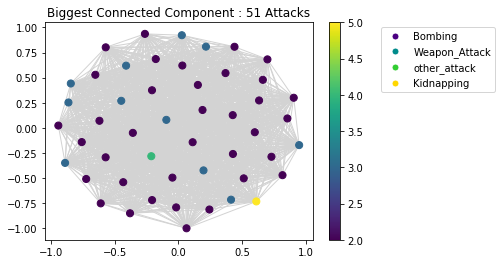

In [163]:
#graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(giant_component))
graph = GG
coords = nx.spring_layout(graph)

im = nx.draw_networkx_nodes(graph, coords, node_size=50,node_color=labels_giant, edge_labels=labels_giant)
nx.draw_networkx_edges(graph, coords, edge_color='lightgray')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Bombing',
                          markerfacecolor='indigo', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Weapon_Attack',
                          markerfacecolor='darkcyan', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='other_attack',
                          markerfacecolor='limegreen', markersize=7),
                  Line2D([0], [0], marker='o', color='w', label='Kidnapping',
                          markerfacecolor='gold', markersize=7)]

plt.colorbar(im)
plt.legend(handles=legend_elements,bbox_to_anchor=(1.7, 1))

plt.title("Biggest Connected Component : 51 Attacks")

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Second Biggest Connected Component : 29 Attacks')

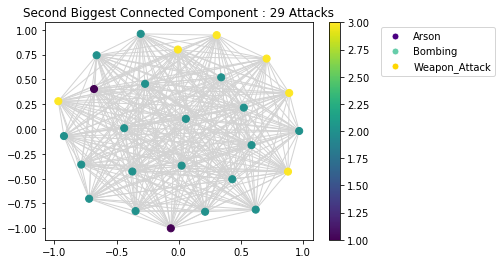

In [166]:
#graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(second_giant))
graph = GG2
coords = nx.spring_layout(graph)

im = nx.draw_networkx_nodes(graph, coords, node_size=50, node_color=labels_second_giant, edge_labels=labels_second_giant)
nx.draw_networkx_edges(graph, coords, edge_color='lightgray')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Arson',
                          markerfacecolor='indigo', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Bombing',
                          markerfacecolor='mediumaquamarine', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Weapon_Attack',
                          markerfacecolor='gold', markersize=7)]

plt.colorbar(im)
plt.legend(handles=legend_elements,bbox_to_anchor=(1.7, 1))
plt.title("Second Biggest Connected Component : 29 Attacks")

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Third Biggest Connected Component : 19 Attacks')

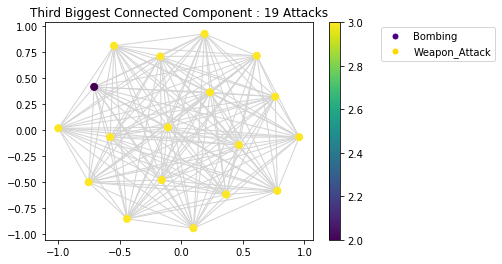

In [168]:
#graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(second_giant))
graph = GG3
coords = nx.spring_layout(graph)

im = nx.draw_networkx_nodes(graph, coords, node_size=50, node_color=labels_third_giant, edge_labels=labels_third_giant)
nx.draw_networkx_edges(graph, coords, edge_color='lightgray')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Bombing',
                          markerfacecolor='indigo', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Weapon_Attack',
                          markerfacecolor='gold', markersize=7)]

plt.colorbar(im)
plt.legend(handles=legend_elements,bbox_to_anchor=(1.7, 1))
plt.title("Third Biggest Connected Component : 19 Attacks")

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Fourth Biggest Connected Component : 19 Attacks')

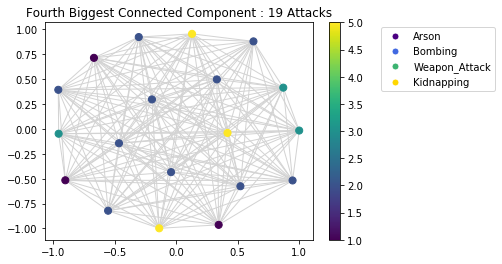

In [173]:
#graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(second_giant))
graph = GG4
coords = nx.spring_layout(graph)

im = nx.draw_networkx_nodes(graph, coords, node_size=50, node_color=labels_fourth_giant, edge_labels=labels_fourth_giant)
nx.draw_networkx_edges(graph, coords, edge_color='lightgray')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Arson',
                          markerfacecolor='indigo', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Bombing',
                          markerfacecolor='royalblue', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Weapon_Attack',
                          markerfacecolor='mediumseagreen', markersize=7),
                  Line2D([0], [0], marker='o', color='w', label='Kidnapping',
                          markerfacecolor='gold', markersize=7)]

plt.colorbar(im)
plt.legend(handles=legend_elements,bbox_to_anchor=(1.7, 1))
plt.title("Fourth Biggest Connected Component : 19 Attacks")

### Incidence Matrix


In [ ]:
S_complete = nx.incidence_matrix(G)

S_giant_component = nx.incidence_matrix(GG)

S_second_giant_component = nx.incidence_matrix(GG2)

### Features

In [ ]:
def features_nodes(nb):
    compt = 0
    nodes_ex = [None]*features.shape[0]
    for i in range (0,features.shape[0]):
        if features[i][nb] == 1:
            nodes_ex [compt] = labels[i]
            compt = compt + 1
    nodes_ex = nodes_ex[0:compt] 
    nb_arson = 0
    nb_bombing = 0
    nb_weapon_attack = 0
    nb_kidnapping = 0
    nb_other_attack = 0
    for i in range (0,len(nodes_ex)):
        if nodes_ex[i] == 'Arson':
            nb_arson = nb_arson+1
        elif nodes_ex[i] == 'Bombing':
            nb_bombing = nb_bombing+1
        elif nodes_ex[i] == 'Kidnapping':
            nb_kidnapping = nb_kidnapping+1
        elif nodes_ex[i] == 'Weapon_Attack':
            nb_weapon_attack = nb_weapon_attack+1
        else:
            nb_other_attack = nb_other_attack +1
    if compt != 0:
        print("Percentage of Arson = " + str(nb_arson/compt*100))
        print("Percentage of Bombing = " + str(nb_bombing/compt*100))
        print("Percentage of kidnapping = " + str(nb_kidnapping/compt*100))
        print("Percentage of Weapon attack = " + str(nb_weapon_attack/compt*100))
        print("Percentage of Other attack = " + str(nb_other_attack/compt*100))
    
    return nodes_ex

In [ ]:
nodes_1 = features_nodes(16) #when the 1st column of features == 1